In [44]:
import numpy as np 
from scipy.integrate import odeint
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate1 as sr1
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import seaborn as sns
# warnings.filterwarnings('ignore')

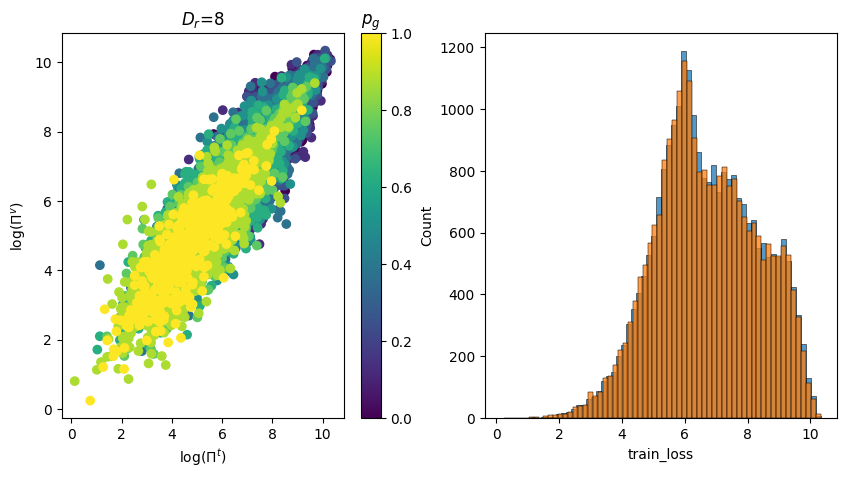

In [78]:
save_folder = '../data/L63-Strategy-varying-featuresize/'
D_r = 8
bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folder+str(D_r))
data = bsa.get_data()
N, N_ = 20000, round(2.0*1./(0.91*0.02))
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
penalty = 0*bsa.beta * (data['||W||'] * bsa.D_r)**2
x = (data['train_loss'] )
y = (data['test_loss_two_single'])
im = ax.scatter(np.log(x), np.log(y), c=data['good_rows_W_in'])
ax.set_xlabel(r'$\log(\Pi^t)$')
ax.set_ylabel(r'$\log(\Pi^v)$')
ax.set_title(r'$D_r$='+f'{D_r}')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_title('$p_g$')
sns.histplot(np.log(x), ax=ax1)
sns.histplot(np.log(y), ax=ax1)
plt.savefig(f'../data/plots/train_vs_test_D_r_{D_r}.png')

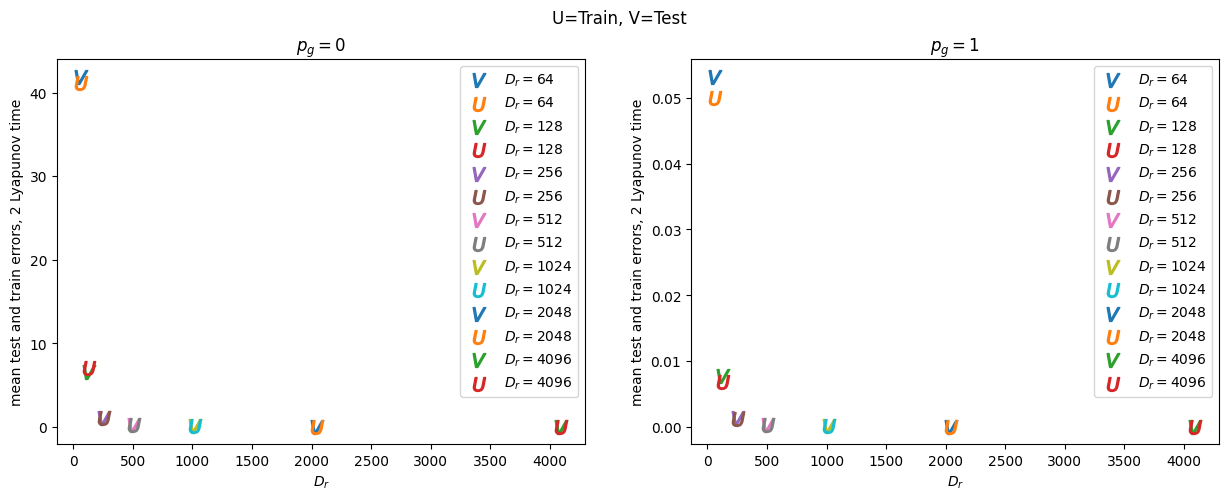

In [97]:
save_folder = '../data/L63-Strategy-varying-featuresize/'
D_r = 4096

percents = 50
dx = 100./percents
p = np.arange(0., 100. + dx, dx) / 100.
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
# ax.axhline(y=1, color='black')
for D_r in [4096, 2048, 1024, 512, 256, 128, 64][::-1]:
    bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folder+str(D_r))
    data = bsa.get_data()
    penalty = 0.*bsa.beta * (bsa.get_line('||W||')[0] * bsa.D_r)**2 
    train_loss = bsa.get_line('train_loss')[0]+ penalty
    test_loss = bsa.get_line('test_loss_two_single')[0] + penalty
    y = (test_loss) / (train_loss)
    ax.scatter(D_r, test_loss[0], label=fr'$D_r={{{D_r}}}$', marker=r'$V$', s=100)
    ax.scatter(D_r, train_loss[0], label=fr'$D_r={{{D_r}}}$', marker=r'$U$', s=100)
    ax1.scatter(D_r, test_loss[-1], label=fr'$D_r={{{D_r}}}$', marker=r'$V$', s=100)
    ax1.scatter(D_r, train_loss[-1], label=fr'$D_r={{{D_r}}}$', marker=r'$U$', s=100)
    
    
ax.set_xlabel(r'$D_r$')
ax.set_ylabel(r'mean test and train errors, 2 Lyapunov time')
ax.set_title(r'$p_g=0$')
ax1.set_xlabel(r'$D_r$')
ax1.set_ylabel(r'mean test and train errors, 2 Lyapunov time')
ax1.set_title(r'$p_g=1$')
ax.legend()
ax1.legend()
yticks = ax.get_yticks()
yticklabels = ax.get_yticklabels()
fig.suptitle(r'U=Train, V=Test')
# ax.set_yticks(yticks + [1.0])
# ax.set_ylim((0., 20.))
plt.savefig(f'../data/plots/bias_variance.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


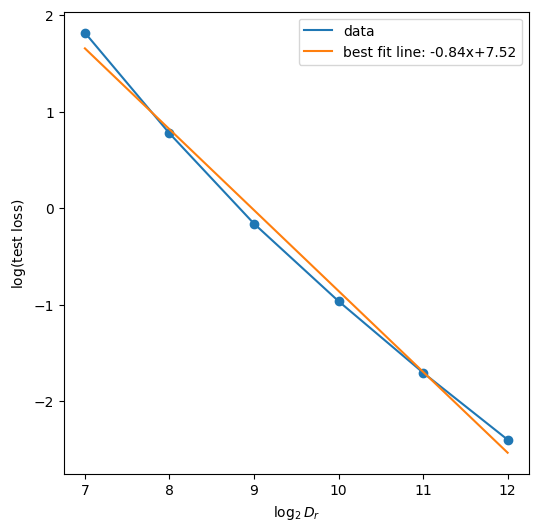

In [43]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

all_D_r = [2**n for n in [4, 5, 6, 7, 8, 9, 10, 11, 12]][3:]
err_at_idx_test = []
mean_err_test = []
err_at_idx_train = []
mean_err_train = []
err_at_idx_test_beta = []
mean_err_test_beta = []
err_at_idx_train_beta = []
mean_err_train_beta = []

W_at_idx = []
mean_W = []

index = -1
midx = 0
save_folder = '../data/L63-Strategy-varying-featuresize/'

for i, D_r in enumerate(all_D_r):
    bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folder+str(D_r))
    mse = bsa.get_line('test_loss_two_single')[0] #- bsa.beta * (bsa.get_line('||W||')[0] * bsa.D_r)**2
    # ax.plot(bsa.percents, np.log2(mse), label=fr'$D_r=${D_r}')
    # ax.scatter(np.log2(D_r), np.log(mse[index]), s=5)
    err_at_idx_test.append(mse[index])
    mean_err_test.append(mse[midx:].mean())


    

ax.set_xlabel(r'$\log_2{D_r}$')
ax.set_ylabel(r'$\log({\rm test}$ ${\rm loss})$')
ax.legend()

y = np.log(err_at_idx_test)
x = np.log2(all_D_r)
lr = stats.linregress(x, y)
a, b = lr.slope, lr.intercept
ax.plot(x, y, label=r'data')
ax.scatter(x, y)
ax.plot(x, a*x+b, label=fr'best fit line: {a:.2f}x+{b:.2f}')
ax.legend()


plt.savefig('../data/plots/test_loss_vs_D_r_2.png')

**Linear rows to check overfitting**

In [65]:
D, D_r = 3, 256
p = 100.
G = int(D_r * p / 100.)
L = int((D_r - G)*1.)
E = D_r - (G + L)
if G == D_r:
    name = 'good'
elif E == 0:
    name = 'linear'
else:
    name = 'extreme'
save_folder = f'../data/overfit_tau_f/{D_r}_full_g'#f'../data/overfit_tau_f/{name}_D_r_{D_r}_p_g_{p}_p_l_{}'
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 4e-5
L0, L1 = 0.4, 3.5
percents = 50
n_repeats = 500
n_models = percents * n_repeats
row_selection = 'good_50_50'
train_option = 'random_20000'
repo = '..'
L63_data_folder = '{}/data/L63-trajectories'.format(repo)
train = np.load('{}/train.npy'.format(L63_data_folder))
test = np.load('{}/test.npy'.format(L63_data_folder))[:, :1000, :]
limits_W_in, limits_W = [-0.1, 0.1], [-.5, .5]

batch = sr1.BatchStrategy_SMLR(save_folder, D, D_r, n_repeats, beta, error_threshold, train, test, dt, Lyapunov_time, L0, L1, percents,\
                          row_selection, train_option, limits_W_in, limits_W)
batch.run_single_partition([G, L, E], length=1374, save_data=True)
# bsa = sr1.BatchStrategyAnalyzer_SMLR(batch.save_folder)
# bsa.compute_train_loss(train)
# bsa.compute_test_loss_single(test)

Working on batch 0 ...
Time taken by sample_parallel is 0.9128 seconds
Running experiments ...
Documenting results ...
Time taken by run_single_partition is 11.8501 seconds


In [24]:
def get_folder(D_r=300, row='G', p=50):
    if row == 'G':
        name = 'good'
    elif row == 'L':
        name = 'linear'
    else:
        name = 'extreme'
    return f'../data/overfit_tau_f/{name}_D_r_{D_r}_p_good_{p}'
D_r_1, D_r_2 = 256, 256*8
p = 12.5
bsa_g = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_1, row='G', p=100.0))
bsa_g_2 = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_2, row='G', p=100.0))
bsa_l = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_2, row='L', p=0.))
bsa_l_2 = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_2, row='L', p=0.))
bsa_e = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_2, row='E', p=0.))
bsa_e_2 = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_2, row='E', p=0.))

data_g = bsa_g.get_data()
data_g_2 = bsa_g_2.get_data()
data_l = bsa_l.get_data()
data_l_2 = bsa_l_2.get_data()
data_e = bsa_e.get_data()
data_e_2 = bsa_e_2.get_data()

penalty_g = 0 * bsa_g.beta * (data_g['||W||'] * bsa_g.D_r)**2
penalty_l = 0 * bsa_l.beta * (data_l['||W||'] * bsa_l.D_r)**2
penalty_e = 0 * bsa_e.beta * (data_e['||W||'] * bsa_e.D_r)**2

train_g, test_g = data_g['tau_f_se_train'] - penalty_g, data_g['tau_f_se'] - penalty_g
train_g_2, test_g_2 = data_g_2['tau_f_se_train'], data_g_2['tau_f_se'] 
train_l_2, test_l_2 = data_l_2['tau_f_se_train'], data_l_2['tau_f_se'] 
train_e_2, test_e_2 = data_e_2['tau_f_se_train'], data_e_2['tau_f_se'] 
train_l, test_l = data_l['tau_f_se_train'] - penalty_l, data_l['tau_f_se'] - penalty_l
train_e, test_e = data_e['tau_f_se_train'] - penalty_e, data_e['tau_f_se'] - penalty_e

mtr_g, mtr_l, mtr_e = (train_g).mean(), (train_l).mean(), (train_e).mean()
mte_g, mte_l, mte_e = (test_g).mean(), (test_l).mean(), (test_e).mean()
mtr_l_d = (mtr_l - mtr_g) / mtr_g
mtr_e_d = (mtr_e - mtr_g) / mtr_g
mte_l_d = (mte_l - mte_g) / mte_g
mte_e_d = (mte_e - mte_g) / mte_g

fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
sns.histplot((test_g), label=fr'$D_r={D_r_1}, p_g=1, \mu$={mte_g:.2f}', ax=ax)
sns.histplot((test_l), label=fr'$D_r={D_r_2}, p_g={p/100},\,p_e=0, \mu$={mte_l:.2f} ({mte_l_d*100:.2f}%)', ax=ax)
sns.histplot((test_e), label=fr'$D_r={D_r_2}, p_l=0,\,p_g={p/100}, \mu$={mte_e:.2f} ({mte_e_d*100:.2f}%)', ax=ax)
# sns.histplot((test_g_2), label=fr'$D_r={D_r_2}, p_l=0,\,p_g=1.0, \mu$={mtr_e:.2f} ({mtr_e_d*100:.2f}%)', ax=ax)
# sns.histplot((test_l_2), label=fr'$D_r={D_r_2}, p_l=1.0,\,p_g=0.0, \mu$={mtr_e:.2f} ({mtr_e_d*100:.2f}%)', ax=ax)
ax.set_title('log test loss')
ax.legend()

sns.histplot((train_g_2), label=fr'$D_r={D_r_1}, p_g=1, \mu$={np.mean(train_g_2):.2f}', ax=ax1)
sns.histplot((train_l_2), label=fr'$D_r={D_r_2}, p_g={p/100},\,p_e=0, \mu$={np.mean(train_l_2):.2f} ({mtr_l_d*100:.2f}%)', ax=ax1)
sns.histplot((train_e_2), label=fr'$D_r={D_r_2}, p_l=0,\,p_g={p/100}, \mu$={np.mean(train_e_2):.2f} ({mtr_e_d*100:.2f}%)', ax=ax1)
# sns.histplot((train_g_2), label=fr'$D_r={D_r_2}, p_l=0,\,p_g=1.0, \mu$={np.mean(train_g_2):.2f} ({mtr_e_d*100:.2f}%)', ax=ax1)
# sns.histplot((train_l_2), label=fr'$D_r={D_r_2}, p_l=1.0,\,p_g=0.0, \mu$={np.mean(train_l_2):.2f} ({mtr_e_d*100:.2f}%)', ax=ax1)
ax1.set_title('log train loss')
ax1.legend()

NameError: name 'bsa_e_2' is not defined

Time taken by compute_error is 0.0297 seconds
Time taken by compute_train_error is 0.0491 seconds
Time taken by compute_error is 0.0242 seconds
Time taken by compute_train_error is 0.0446 seconds
Time taken by compute_error is 0.0332 seconds
Time taken by compute_train_error is 0.0402 seconds
Time taken by compute_error is 0.0207 seconds
Time taken by compute_train_error is 0.0412 seconds
Time taken by compute_error is 0.0131 seconds
Time taken by compute_train_error is 0.0295 seconds
Time taken by compute_error is 0.0202 seconds
Time taken by compute_train_error is 0.0399 seconds
Time taken by compute_error is 0.0330 seconds
Time taken by compute_train_error is 0.0640 seconds
Time taken by compute_error is 0.0314 seconds
Time taken by compute_train_error is 0.0523 seconds
Time taken by compute_error is 0.0201 seconds
Time taken by compute_train_error is 0.0331 seconds
Time taken by compute_error is 0.0281 seconds
Time taken by compute_train_error is 0.0481 seconds
Time taken by comput

In [ ]:
e, N = 0.67, 300
m, M = 0.4, 3.5
A = m + e
B = M - e
a = m
diff = []
for i in range(5000):
    M = np.random.uniform(low=A, high=B, size=N)
    m = np.random.uniform(low=A, high=M, size=N)
    diff.append((M-m).mean())
sns.histplot(diff)
plt.savefig('../data/sim_dist.png')

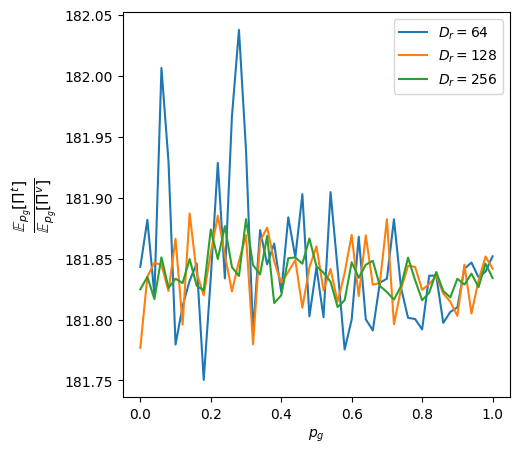

In [47]:
save_folder = '../data/L63-Strategy-varying-featuresize/'
D_r = 4096
N, N_ = 20000, round(2.0*1./(0.91*0.02))
percents = 50
dx = 100./percents
p = np.arange(0., 100. + dx, dx) / 100.
z = np.zeros_like(p)
    
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.axhline(y=1, color='black')
for D_r in [256, 128, 64][::-1]:
    bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folder+str(D_r))
    a = np.unique(bsa.get_data()['good_rows_W_in'])
    for i in range(len(p)):
        data = bsa.get_data()
        data = data[data['good_rows_W_in']==a[i]]
        penalty = bsa.beta * (data['||W||'] * bsa.D_r)**2 * 1.
        train_loss = data['train_loss'] + penalty
        test_loss = data['test_loss_two_single'] + penalty
        y = (test_loss/N_) / (train_loss/N)
        z[i] = np.mean(y)
    ax.plot(p[0:], z[0:], label=fr'$D_r={{{D_r}}}$')
    
    # ax.set_title(r'ratio of testing and training errors')
    # fig.colorbar(im, ax=ax)
ax.legend()
yticks = ax.get_yticks()
yticklabels = ax.get_yticklabels()
# ax.set_yticks(yticks + [1.0])
# ax.set_ylim((0., 45.))
ax.set_xlabel(r'$p_g$')
ax.set_ylabel(r'$\frac{\mathbb{E}_{p_g}[\Pi^t]}{\mathbb{E}_{p_g}[\Pi^v]}$', fontsize=16)
plt.savefig(f'../data/plots/train_vs_test.png', bbox_inches='tight', dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: 'data/L63-Strategy-varying-featuresize/64/config.json'

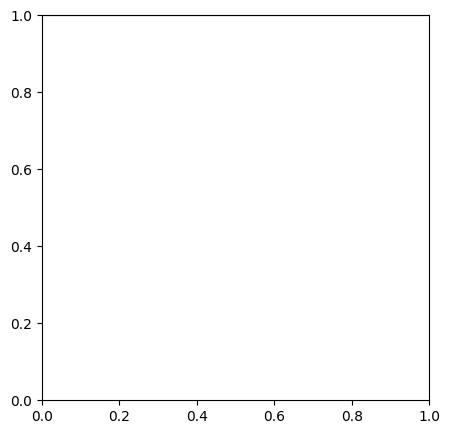

In [66]:
save_folder = '../data/L63-Strategy-varying-featuresize/'
D_r = 4096
N, N_ = 20000, round(2.0*1./(0.91*0.02))
percents = 50
dx = 100./percents
p = np.arange(0., 100. + dx, dx) / 100.
z = np.zeros_like(p)
    
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.axhline(y=1, color='black')
for D_r in [4096, 2048, 1024, 512, 256, 128, 64][::-1]:
    bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folder+str(D_r))
    a = np.unique(bsa.get_data()['good_rows_W_in'])

    data = bsa.get_data()
    penalty = bsa.beta * (bsa.get_line('||W||')[0] * bsa.D_r)**2 * 0.
    train_loss = bsa.get_line('train_loss')[0] - penalty
    test_loss = bsa.get_line('test_loss_two_single')[0] - penalty
    y = (test_loss/test_loss[-1]) / (train_loss/train_loss[-1])
    ax.scatter(D_r, y.mean(), label=fr'$D_r={{{D_r}}}$')
    
    # ax.set_title(r'ratio of testing and training errors')
    # fig.colorbar(im, ax=ax)
ax.legend()
yticks = ax.get_yticks()
yticklabels = ax.get_yticklabels()
# ax.set_yticks([1, 10, 20, 30, 40])
# ax.set_ylim((0., 45.))
ax.set_xlabel(r'$p_g$')
ax.set_ylabel(r'$\frac{\mathbb{E}_{p_g}[\Pi^t]}{\mathbb{E}_{p_g}[\Pi^v]}$', fontsize=16)
plt.savefig(f'../data/plots/train_vs_test.png', bbox_inches='tight', dpi=300)

In [6]:
round(25.0*1./(0.91*0.02))

1374

Text(0.5, 1.0, 'log train loss')

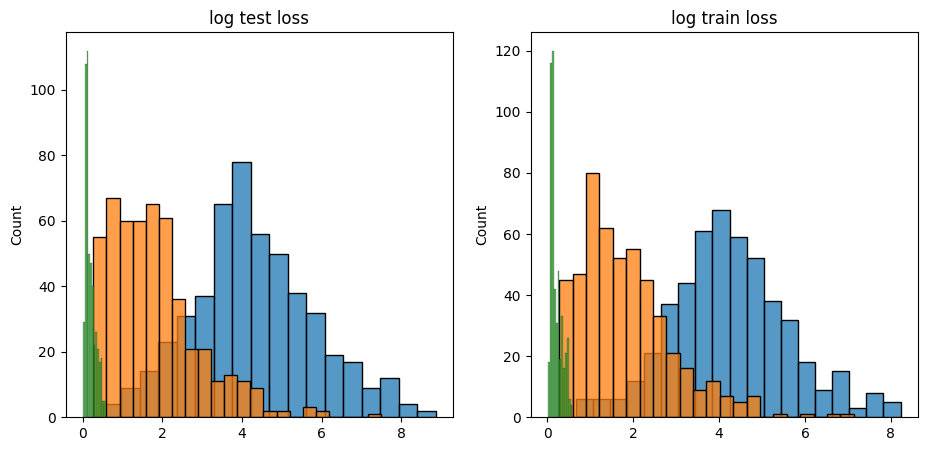

Time taken by compute_error is 0.0048 seconds
Time taken by compute_train_error is 0.0083 seconds
Time taken by compute_error is 0.0085 seconds
Time taken by compute_train_error is 0.0079 seconds
Time taken by compute_error is 0.0038 seconds
Time taken by compute_train_error is 0.0101 seconds
Time taken by compute_error is 0.0032 seconds
Time taken by compute_train_error is 0.0054 seconds
Time taken by compute_error is 0.0055 seconds
Time taken by compute_train_error is 0.0067 seconds
Time taken by compute_error is 0.0039 seconds
Time taken by compute_train_error is 0.0120 seconds
Time taken by compute_error is 0.0089 seconds
Time taken by compute_train_error is 0.0066 seconds
Time taken by compute_error is 0.0082 seconds
Time taken by compute_train_error is 0.0053 seconds
Time taken by compute_error is 0.0107 seconds
Time taken by compute_train_error is 0.0052 seconds
Time taken by compute_error is 0.0047 seconds
Time taken by compute_train_error is 0.0071 seconds
Time taken by comput

In [70]:
bsa_g = sr1.BatchStrategyAnalyzer_SMLR('data/overfit_tau_f/256_full_g')
bsa_g_2 = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_2, row='G', p=100.0))
bsa_l = sr1.BatchStrategyAnalyzer_SMLR('data/overfit_tau_f/256_full_l')
bsa_l_2 = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_2, row='L', p=0.))
bsa_e = sr1.BatchStrategyAnalyzer_SMLR('data/overfit_tau_f/256_full_e')
bsa_e_2 = sr1.BatchStrategyAnalyzer_SMLR(get_folder(D_r=D_r_2, row='E', p=0.))

data_g = bsa_g.get_data()
data_g_2 = bsa_g_2.get_data()
data_l = bsa_l.get_data()
data_l_2 = bsa_l_2.get_data()
data_e = bsa_e.get_data()
data_e_2 = bsa_e_2.get_data()

penalty_g = 0 * bsa_g.beta * (data_g['||W||'] * bsa_g.D_r)**2
penalty_l = 0 * bsa_l.beta * (data_l['||W||'] * bsa_l.D_r)**2
penalty_e = 0 * bsa_e.beta * (data_e['||W||'] * bsa_e.D_r)**2

train_g, test_g = data_g['tau_f_se_train'] - penalty_g, data_g['tau_f_se'] - penalty_g
# train_g_2, test_g_2 = data_g_2['tau_f_se_train'], data_g_2['tau_f_se'] 
# train_l_2, test_l_2 = data_l_2['tau_f_se_train'], data_l_2['tau_f_se'] 
# train_e_2, test_e_2 = data_e_2['tau_f_se_train'], data_e_2['tau_f_se'] 
train_l, test_l = data_l['tau_f_se_train'] - penalty_l, data_l['tau_f_se'] - penalty_l
train_e, test_e = data_e['tau_f_se_train'] - penalty_e, data_e['tau_f_se'] - penalty_e

mtr_g, mtr_l, mtr_e = (train_g).mean(), (train_l).mean(), (train_e).mean()
mte_g, mte_l, mte_e = (test_g).mean(), (test_l).mean(), (test_e).mean()
mtr_l_d = (mtr_l - mtr_g) / mtr_g
mtr_e_d = (mtr_e - mtr_g) / mtr_g
mte_l_d = (mte_l - mte_g) / mte_g
mte_e_d = (mte_e - mte_g) / mte_g

fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
sns.histplot((test_g), label=fr'$D_r={D_r_1}, p_g=1, \mu$={mte_g:.2f}', ax=ax)
sns.histplot((test_l), label=fr'$D_r={D_r_2}, p_g={p/100},\,p_e=0, \mu$={mte_l:.2f} ({mte_l_d*100:.2f}%)', ax=ax)
sns.histplot((test_e), label=fr'$D_r={D_r_2}, p_l=0,\,p_g={p/100}, \mu$={mte_e:.2f} ({mte_e_d*100:.2f}%)', ax=ax)
# sns.histplot((test_g_2), label=fr'$D_r={D_r_2}, p_l=0,\,p_g=1.0, \mu$={mtr_e:.2f} ({mtr_e_d*100:.2f}%)', ax=ax)
# sns.histplot((test_l_2), label=fr'$D_r={D_r_2}, p_l=1.0,\,p_g=0.0, \mu$={mtr_e:.2f} ({mtr_e_d*100:.2f}%)', ax=ax)
ax.set_title('log test loss')
# ax.legend()

sns.histplot((train_g), label=fr'$D_r={D_r_1}, p_g=1, \mu$={np.mean(train_g):.2f}', ax=ax1)
sns.histplot((train_l), label=fr'$D_r={D_r}, p_g={p/100},\,p_e=0, \mu$={np.mean(train_l):.2f} ({mtr_l_d*100:.2f}%)', ax=ax1)
sns.histplot((train_e), label=fr'$D_r={D_r}, p_l=0,\,p_g={p/100}, \mu$={np.mean(train_e):.2f} ({mtr_e_d*100:.2f}%)', ax=ax1)
# sns.histplot((train_g_2), label=fr'$D_r={D_r_2}, p_l=0,\,p_g=1.0, \mu$={np.mean(train_g_2):.2f} ({mtr_e_d*100:.2f}%)', ax=ax1)
# sns.histplot((train_l_2), label=fr'$D_r={D_r_2}, p_l=1.0,\,p_g=0.0, \mu$={np.mean(train_l_2):.2f} ({mtr_e_d*100:.2f}%)', ax=ax1)
ax1.set_title('log train loss')
# ax1.legend()

In [80]:
D, D_r = 3, 8
p = 0.
G = int(D_r * p / 100.)
L = int((D_r - G)*0.)
E = D_r - (G + L)
if G == D_r:
    name = 'good'
elif E == 0:
    name = 'linear'
else:
    name = 'extreme'
save_folder = f'../data/overfit_tau_f/{D_r}_full_e'#f'../data/overfit_tau_f/{name}_D_r_{D_r}_p_g_{p}_p_l_{}'
Lyapunov_time, dt = 1./.91, 0.02
error_threshold = 0.05
beta = 4e-5
L0, L1 = 0.4, 3.5
percents = 50
n_repeats = 500
n_models = percents * n_repeats
row_selection = 'good_50_50'
train_option = 'random_20000'
repo = '..'
L63_data_folder = '{}/data/L63-trajectories'.format(repo)
train = np.load('{}/train.npy'.format(L63_data_folder))
test = np.load('{}/test.npy'.format(L63_data_folder))[:, :1000, :]
limits_W_in, limits_W = [-0.1, 0.1], [-.5, .5]

batch = sr1.BatchStrategy_SMLR(save_folder, D, D_r, n_repeats, beta, error_threshold, train, test, dt, Lyapunov_time, L0, L1, percents,\
                          row_selection, train_option, limits_W_in, limits_W)
batch.run_single_partition([G, L, E], length=1374, save_data=True)
bsa = sr1.BatchStrategyAnalyzer_SMLR(batch.save_folder)
bsa.compute_train_loss(train, penalty=False)
bsa.compute_test_loss_single(test, penalty=False)

Working on batch 0 ...
Time taken by sample_parallel is 0.1787 seconds
Running experiments ...


/Users/pman0581/Documents/GitHub/random-feature-map/modules/surrogate.py:76: RuntimeWarning: overflow encountered in matmul
  R = np.tanh(self.W_in @ obs[:, :-1] + self.b_in[:, np.newaxis])#np.hstack([self.phi(uo).reshape(-1, 1) for uo in obs.T])
/Users/pman0581/Documents/GitHub/random-feature-map/modules/surrogate.py:65: RuntimeWarning: overflow encountered in matmul
  return np.tanh(self.W_in @ uo + self.b_in)
/Users/pman0581/Documents/GitHub/random-feature-map/modules/surrogate1.py:209: RuntimeWarning: overflow encountered in matmul
  features = np.abs(np.tanh(model.W_in@self.bad_feature_count_trajectory + model.b_in[:,np.newaxis]))
/Users/pman0581/Documents/GitHub/random-feature-map/modules/surrogate.py:76: RuntimeWarning: overflow encountered in matmul
  R = np.tanh(self.W_in @ obs[:, :-1] + self.b_in[:, np.newaxis])#np.hstack([self.phi(uo).reshape(-1, 1) for uo in obs.T])
/Users/pman0581/Documents/GitHub/random-feature-map/modules/surrogate.py:65: RuntimeWarning: overflow encount

Documenting results ...
Time taken by run_single_partition is 1.2377 seconds
Computing loss for percent id: 0 ...


/Users/pman0581/Documents/GitHub/random-feature-map/modules/surrogate.py:95: RuntimeWarning: overflow encountered in matmul
  return self.W @ np.tanh(self.W_in @ u + self.b_in[:, np.newaxis])


Time taken for batch of training loss computations = 5.18s
Time taken by compute_train_loss is 5.1953 seconds
Computing loss for percent id: 0 ...


/Users/pman0581/Documents/GitHub/random-feature-map/modules/surrogate.py:95: RuntimeWarning: overflow encountered in matmul
  return self.W @ np.tanh(self.W_in @ u + self.b_in[:, np.newaxis])


500
Time taken for batch of testing loss computations = 0.27s
Time taken by compute_test_loss_single is 0.2814 seconds


In [84]:
save_folder = '../data/L63-Strategy-varying-featuresize/'
D_r = 64
bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folder+str(D_r))
# bsa = sr1.BatchStrategyAnalyzer_SMLR(f'../data/overfit_tau_f/{D_r}_full_e')
data = bsa.get_data()
bsa.get_line('train_loss')[0]/ bsa.get_line('test_loss_two_single')[0]

array([0.98258575, 0.96982209, 1.02749049, 0.89808905, 0.98642286,
       1.03340399, 1.04090019, 1.00785389, 1.00612077, 1.02517629,
       0.94959713, 1.0458778 , 1.04412437, 0.86702993, 0.88764622,
       0.93425493, 1.00682783, 0.9434163 , 1.00247815, 0.99013544,
       1.01347933, 0.88422468, 0.92109028, 0.83569001, 1.05946968,
       0.99072716, 1.06148387, 0.85636932, 0.90374928, 1.04569024,
       0.94769398, 0.91595405, 1.00718889, 1.02566243, 0.98763825,
       1.02008926, 0.90481959, 0.98200199, 1.04327248, 1.04673061,
       1.04655265, 1.0104501 , 0.94004873, 1.07159774, 0.95279428,
       1.0025475 , 0.95223644, 0.9228652 , 1.01912441, 0.97072669,
       0.93904072])

In [83]:
save_folder = '../data/L63-Strategy-varying-featuresize/'
D_r = 64
bsa = sr1.BatchStrategyAnalyzer_SMLR(save_folder+str(D_r))
# bsa = sr1.BatchStrategyAnalyzer_SMLR(f'../data/overfit_tau_f/{D_r}_full_g')
data = bsa.get_data()
data['train_loss'].mean() / data['test_loss_two_single'].mean()

178.94557583076983